# Time Series Forecasting with GPy

Instead of writing the code from scratch, as in the other notebooks on Gaussian Process (GP) regression, it is ususally much more convenient and efficient to use developed packages.

In this notebook we are going to demonstrate forecasting using the GPy package to perform GP regression on the electricity production time series dataset taken from Kaggle. GPy is a powerful Python package for working with GPs and posseses a wide array of features (just one of the many excellent available open-source options).

We begin by importing the required libraries.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import GPy

Next we read in the data and plot it.

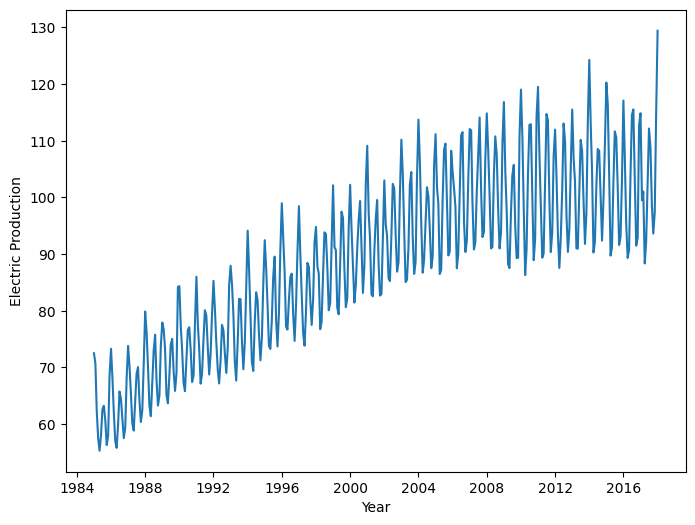

In [2]:
# import the data
df = pd.read_csv("Electric_Production.csv")
df = df.set_index('DATE')
# extract the dates and convert to datetimes (for improving the appearance of the plot)
dates = df.index
dates = [datetime.strptime(i, '%m-%d-%Y') for i in dates]
# plot the data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(dates, df.Value)
ax.set_xlabel("Year")
ax.set_ylabel("Electric Production")
plt.show()

Since GPs require numerical input we are going to define a function that converts the dates into floats. It will be useful if the difference between dates a year apart is calculated as one, so we design the function with this in mind.

In [3]:
def dates_to_floats(dates):
    """Function that converts datetime objects into floats, with 
    zero set to coincide with the date of our first observation."""
    
    reference_time = pd.to_datetime("1985-01-01")
    floats = []
    for i in dates:
        float = (i - reference_time) / pd.Timedelta(365, "D")
        floats.append(float)
        
    return np.asarray(floats)

Now we can define the training and testing sets for our model.

In [4]:
# get t and y values
t = dates_to_floats(dates)
y = df.Value.values
# define training and testing sets
t_train = t[:300].reshape(-1,1)
t_test = t[300:].reshape(-1,1)
y_train = y[:300].reshape(-1,1)
y_test = y[300:].reshape(-1,1)

It is time to choose a suitable covariance function for our GP. Let's pretend that we haven't seen the data but we do have expertise in the area of electricity production. Long-term we expect electricity production to increase in a roughly linear fashion as the population size grows. Without knowing the particular country this data is taken from, we might also expect there to be seasonal variations: a large spike in electricity production in the winter months when people are heating their homes, and a smaller spike in the summer months when some will use air-conditioning to cope with the higher temperatures.

Therefore, we are going to use the Radial Basis Function (RBF) covariance with a large length-scale to model the long-term relationship, and the periodic kernel with a period $p=1$ (remember that we defined the dates_to_floats function so that dates a year apart have a difference of one) to model the seasonal variations. We will combine these two kernels with simple addition. We don't need to add any observation noise as the model does this automatically.

In [5]:
# define RBF kernel and show parameters
k_rbf = GPy.kern.RBF(input_dim=1)
k_rbf

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


In [6]:
# define periodic kernel and show parameters
k_p = GPy.kern.StdPeriodic(input_dim=1, period=1)
k_p

std_periodic.,value,constraints,priors
variance,1.0,+ve,
period,1.0,+ve,
lengthscale,1.0,+ve,


In [7]:
# add the covariance functions and show the parameters
k_comp = k_rbf + k_p
k_comp

sum.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
std_periodic.variance,1.0,+ve,
std_periodic.period,1.0,+ve,
std_periodic.lengthscale,1.0,+ve,


We are going to utilise a linear mean function for the GP which we hope will model the (expected) linear increase of energy production over time. This is not at all necessary; the GP would cope just fine with a zero or constant mean function and we are only using the linear mean function for the purpose of demonstration. The mean function has a single trainable parameer as can be seen below.

In [8]:
# define a linear mean function
mf = GPy.mappings.Linear(1, 1)
mf

linmap.,value,constraints,priors
A,[-0.75688839],,


Now we define the GP model with its covariance and mean functions. As mentioned above we set the period parameter $p=1$, and constrain the RBF length-scale to a large value in an attempt to capture long-term relationships.

In [9]:
# define the GP model
GP = GPy.models.GPRegression(t_train, y_train, k_comp, mean_function=mf)
# fix the periodic parameter to 1
GP.kern.std_periodic.period.constrain_fixed(1)
# constrain the RBF length-scale to a large value
GP.kern.rbf.lengthscale.constrain_bounded(40,60)

reconstraining parameters GP_regression.sum.rbf.lengthscale


In [10]:
GP

GP_regression.,value,constraints,priors
linmap.A,[-0.75688839],,
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,50.0,"40.0,60.0",
sum.std_periodic.variance,1.0,+ve,
sum.std_periodic.period,1.0,+ve fixed,
sum.std_periodic.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In addition to the model hyperparameters already discussed, the model automatically adds a trainable Gaussian noise parameter to account for observation noise.

Now we train the model hyperparameters. To avoid difficulies with local optima, the optimisation is run a number of times from different starting parameter values. The optimal hyperparamater values are those that produce the largest log marginal likelihood.

In [11]:
GP.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 744.1933260600438
Optimization restart 2/10, f = 744.1933260306656
Optimization restart 3/10, f = 744.1933260428184
Optimization restart 4/10, f = 728.8581485037924
Optimization restart 5/10, f = 744.1933260890519
Optimization restart 6/10, f = 744.1933260818428
Optimization restart 7/10, f = 744.1933263955235
Optimization restart 8/10, f = 744.1933260723318
Optimization restart 9/10, f = 744.1933260653011
Optimization restart 10/10, f = 728.858148855412


Let's have a look at the optimised GP hyperparameters.

In [12]:
GP

GP_regression.,value,constraints,priors
linmap.A,[-0.01634733],,
sum.rbf.variance,5449.881900681244,+ve,
sum.rbf.lengthscale,40.0,"40.0,60.0",
sum.std_periodic.variance,46.78347442232685,+ve,
sum.std_periodic.period,1.0,+ve fixed,
sum.std_periodic.lengthscale,0.08189513551104788,+ve,
Gaussian_noise.variance,5.195804609063551,+ve,


It is time to make predictions with our model on the test set. The predict method will return the GP posterior mean, whilst the predict_quantiles method will provide us with the bounds for the 95% credible interval (alternatively the bounds can be calculated from the posterior covariance).

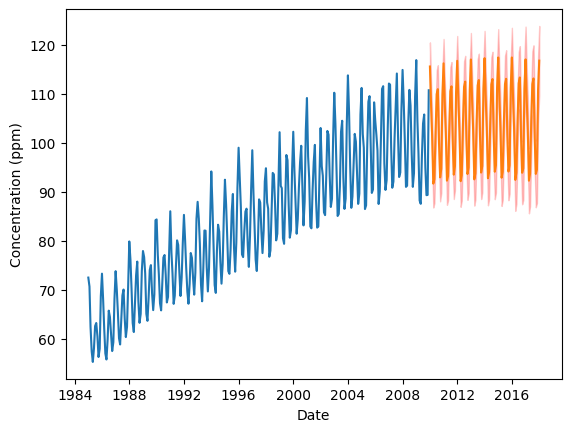

In [13]:
# get the posterior mean and credible interval bounds for the test set
y_mean_pred = GP.predict(t_test)[0] #+ y_train_mean
quants = GP.predict_quantiles(t_test)
lower = quants[0].reshape(97,)
upper = quants[1].reshape(97,)

# plot the predictions on the test set (the GP posterior mean) and the 95% credible interval
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(dates[:300],y_train)
ax.plot(dates[300:],y_mean_pred)
ax.fill_between(dates[300:], lower, upper, alpha=0.2, color="r", label=r"$\pm$ 2 std. dev.")
ax.set_xlabel("Date")
ax.set_ylabel("Concentration (ppm)")
plt.show()

Comparing against the true concentrations, the GP model appears to have produced good predictions on the test set and has captured some important features, such as the slight plateauing of the values from around 2008 onwards, and the seasonal variations.